<a href="https://colab.research.google.com/github/poo5zan/deep_learning_fundamentals/blob/main/assignment_3/rnn_to_predict_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source code: https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/


In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import torch
import torch.nn as nn
import os
import yfinance as yf
import os, contextlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# File Download 
offset = 0
limit = 3000
period = 'max' # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
symbols = ['AAPL','AMZN','META']
limit = limit if limit else len(symbols)
end = min(offset + limit, len(symbols))
is_valid = [False] * len(symbols)
# force silencing of verbose API
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        for i in range(offset, end):
            s = symbols[i]
            data = yf.download(s, period=period)
            if len(data.index) == 0:
                continue
        
            is_valid[i] = True
            file_name = s + ".csv"
            # download_path = os.path.join(root_dir,file_name)
            data.to_csv(file_name)

print('Total number of valid symbols downloaded = {}'.format(sum(is_valid)))

Total number of valid symbols downloaded = 3


In [ ]:
# Attempt 3
# https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/

In [115]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
# symbol = '^IXIC'
symbol = "AAPL"

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=start_date, end=end_date, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# Create a quick overview of the dataset
df.head()

Tensorflow Version: 2.9.2
Num GPUs: 0
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526478,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422664,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410792,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453413,447610800


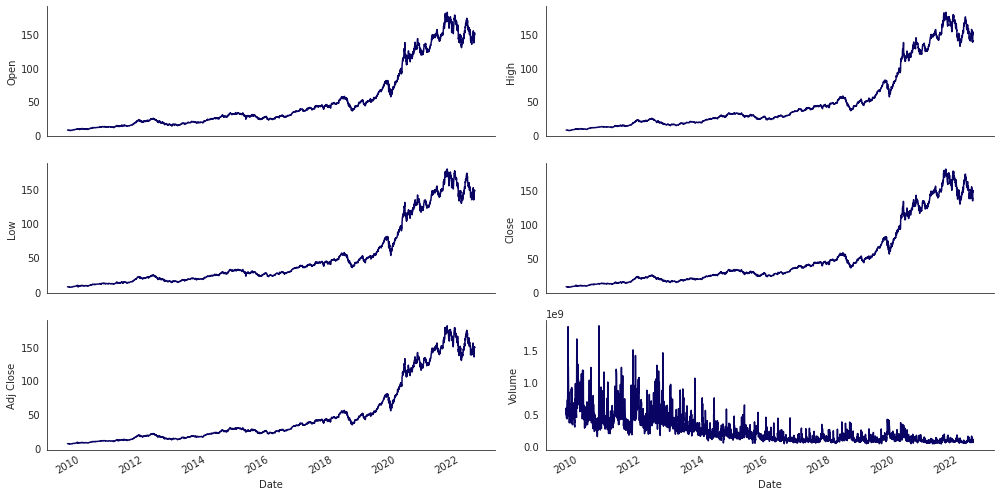

In [104]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [105]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2022-11-10,146.869995,139.500000,141.240005,146.869995,118854000,146.869995
2022-11-11,150.009995,144.369995,145.820007,149.699997,93903800,149.699997
2022-11-14,150.279999,147.429993,148.970001,148.279999,73374100,148.279999
2022-11-15,153.589996,148.559998,152.220001,150.039993,89868300,150.039993
2022-11-16,149.869995,147.289993,149.130005,148.789993,64170900,148.789993


In [106]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3242, 5)


In [107]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2544, 50, 5) (2544,)
(648, 50, 5) (648,)
0.0065392502913691475
0.0065392502913691475


In [128]:
# Configure the neural network model
def get_lstm_model():
    model = Sequential()

    # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
    n_neurons = x_train.shape[1] * x_train.shape[2]
    print(n_neurons, x_train.shape[1], x_train.shape[2])
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    return model

In [122]:
# Configure the neural network model
def get_simple_rnn_model():
    model = Sequential()

    # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
    n_neurons = x_train.shape[1] * x_train.shape[2]
    print(n_neurons, x_train.shape[1], x_train.shape[2])
    model.add(SimpleRNN(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(SimpleRNN(n_neurons, return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    return model

In [125]:
# Plot training & validation loss values
def plot_loss(history, epochs):
    fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
    sns.lineplot(data=history.history["loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
    plt.legend(["Train", "Test"], loc="upper left")
    plt.grid()
    plt.show()

In [124]:
# Training the model
def train_network(model):
    epochs = 20
    batch_size = 16
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,
                        validation_data=(x_test, y_test)
                    )
                        
                        #callbacks=[early_stop])

    # Get the predicted values
    y_pred_scaled = model.predict(x_test)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)
    print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

    # The date from which on the date is displayed
    display_start_date = "2019-01-01" 

    # Add the difference between the valid and predicted prices
    train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
    valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
    valid.insert(1, "y_pred", y_pred, True)
    valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
    df_union = pd.concat([train, valid])

    # Zoom in to a closer timeframe
    df_union_zoom = df_union[df_union.index > display_start_date]

    # Create the lineplot
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("y_pred vs y_test")
    plt.ylabel(stockname, fontsize=18)
    sns.set_palette(["#090364", "#1960EF", "#EF5919"])
    sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

    # Create the bar plot with the differences
    df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
    ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
    plt.legend()
    plt.show()

    df_temp = df[-sequence_length:]
    new_df = df_temp.filter(FEATURES)

    N = sequence_length

    # Get the last N day closing price values and scale the data to be values between 0 and 1
    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)

    # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(last_N_days_scaled)

    # Convert the X_test data set to a numpy array and reshape the data
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

    # Print last price and predicted price for the next day
    price_today = np.round(new_df['Close'][-1], 2)
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

    plus = '+'; minus = ''
    print(f'The close price for {stockname} at {end_date} was {price_today}')
    print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

                        

250 50 5
Epoch 1/20
159/159 [==============================] - 13s 70ms/step - loss: 0.0462 - val_loss: 0.0237
Epoch 2/20
159/159 [==============================] - 11s 67ms/step - loss: 3.5493e-04 - val_loss: 0.0146
Epoch 3/20
159/159 [==============================] - 11s 69ms/step - loss: 5.5463e-04 - val_loss: 0.0057
Epoch 4/20
159/159 [==============================] - 10s 66ms/step - loss: 9.7661e-04 - val_loss: 0.0079
Epoch 5/20
159/159 [==============================] - 10s 62ms/step - loss: 4.4227e-04 - val_loss: 0.0044
Epoch 6/20
159/159 [==============================] - 10s 62ms/step - loss: 4.6678e-04 - val_loss: 0.0027
Epoch 7/20
159/159 [==============================] - 10s 62ms/step - loss: 3.7586e-04 - val_loss: 0.0038
Epoch 8/20
159/159 [==============================] - 10s 62ms/step - loss: 5.9244e-04 - val_loss: 0.0023
Epoch 9/20
159/159 [==============================] - 11s 69ms/step - loss: 6.3591e-04 - val_loss: 0.0059
Epoch 10/20
159/159 [====================

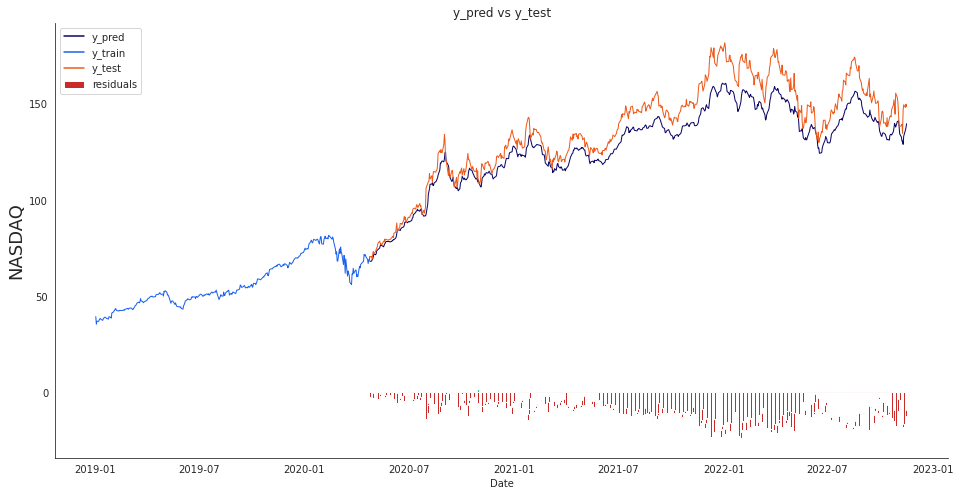

1/1 [==============================] - 0s 26ms/step
The close price for NASDAQ at 2022-11-17 was 148.79
The predicted close price is 139.5 (-6.66%)


In [126]:
# Experiment simple RNN
simple_rnn = get_simple_rnn_model()
train_network(simple_rnn)

250 50 5
Epoch 1/20
159/159 [==============================] - 44s 254ms/step - loss: 4.5711e-04 - val_loss: 8.5342e-04
Epoch 2/20
159/159 [==============================] - 41s 256ms/step - loss: 6.0001e-05 - val_loss: 0.0011
Epoch 3/20
159/159 [==============================] - 41s 257ms/step - loss: 4.9238e-05 - val_loss: 7.9779e-04
Epoch 4/20
159/159 [==============================] - 43s 269ms/step - loss: 4.7448e-05 - val_loss: 0.0015
Epoch 5/20
159/159 [==============================] - 42s 265ms/step - loss: 4.1349e-05 - val_loss: 6.4322e-04
Epoch 6/20
159/159 [==============================] - 42s 265ms/step - loss: 4.6470e-05 - val_loss: 5.9133e-04
Epoch 7/20
159/159 [==============================] - 43s 270ms/step - loss: 3.4527e-05 - val_loss: 5.8298e-04
Epoch 8/20
159/159 [==============================] - 45s 281ms/step - loss: 3.6979e-05 - val_loss: 5.4316e-04
Epoch 9/20
159/159 [==============================] - 47s 299ms/step - loss: 4.1010e-05 - val_loss: 5.0450e-04


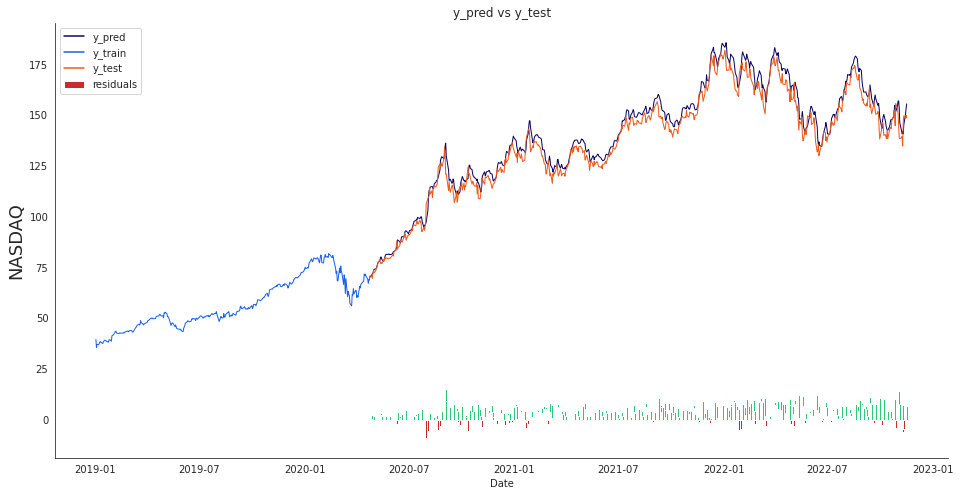

1/1 [==============================] - 0s 38ms/step
The close price for NASDAQ at 2022-11-17 was 148.79
The predicted close price is 154.42999267578125 (+3.65%)


In [129]:
lstm_rnn = get_lstm_model()
train_network(lstm_rnn)